In [1]:
using Clustering, PyPlot
using TextAnalysis
using JLD2
using Statistics
using XLSX
using CSV
using DataFrames
using Dates
using LinearAlgebra
using StatsBase
using MultivariateStats
using Random

In [2]:
include("../src/utill.jl")

make_plots (generic function with 1 method)

In [3]:
new_df = XLSX.readxlsx("../data/Data-Spring/covid-en.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_1 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang])
mask_tmp = ones(Bool, length(en_1.id_str)) 
insert!(en_1, 7, mask_tmp, :tind)


new_df = XLSX.readxlsx("../data/Data-Winter/covid-en.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_2 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang]);

mask_tmp = zeros(Bool, length(en_2.id_str)) 
insert!(en_2, 7, mask_tmp, :tind)

min_dim = minimum([length(en_1.tind), length(en_2.tind)])

df = append!(en_1[1:min_dim, :], en_2[1:min_dim, :]);

df = df[shuffle(1:length(df.favorite_count)), :];

In [4]:
size(df)

(195532, 7)

## Preprocessing:

In [5]:
function preprocess_corp(data)
    data_preprocessed = replace.(data, r"http\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"\S+.com" => s"")
    data_preprocessed = replace.(data_preprocessed, r"resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RESULTING" => s"")
    data_preprocessed = replace.(data_preprocessed, r"#resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"@\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"&amp" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RT\S+" => s"");
    data_preprocessed = replace.(data_preprocessed, contractions...);

    crps_tmp = Corpus(StringDocument.(deepcopy(data_preprocessed)));

    remove_case!(crps_tmp)
    prepare!(crps_tmp, strip_punctuation)
    prepare!(crps_tmp, strip_numbers)
    prepare!(crps_tmp, strip_articles)

    prepare!(crps_tmp, strip_pronouns)
    prepare!(crps_tmp, strip_prepositions)
    prepare!(crps_tmp, strip_definite_articles)
    prepare!(crps_tmp, strip_indefinite_articles)

    prepare!(crps_tmp, strip_stopwords)
    prepare!(crps_tmp, strip_non_letters)
    remove_words!(crps_tmp, ["don", "re", "ve", "ll", "covid", "coronavirus", "via"])
    stem!(crps_tmp)
    prepare!(crps_tmp, strip_whitespace)
    update_lexicon!(crps_tmp)
    return crps_tmp
end

preprocess_corp (generic function with 1 method)

In [6]:
crps = preprocess_corp(df[:,4])

A Corpus with 195532 documents:
 * 195532 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 107438 tokens
Corpus's index contains 0 tokens

In [7]:
# crps_1 = preprocess_corp(df[df.tind,4])
# crps_2 = preprocess_corp(df[.!df.tind,4]);

In [8]:
# Create a vector from merged corpus: 

lexicone_vect = lexicon(crps)

n_max = 120
pairs = sort(collect(lexicone_vect), by=x->x[2], rev=true)[1:n_max]
terms = [i[1] for i in pairs];

In [9]:
terms

120-element Array{String,1}:
 "vaccin"
 "peopl"
 "death"
 "test"
 "pandem"
 "health"
 "time"
 "trump"
 "die"
 "help"
 "day"
 "report"
 "virus"
 ⋮
 "april"
 "tri"
 "quarantin"
 "relief"
 "love"
 "approv"
 "talk"
 "issu"
 "citi"
 "take"
 "recoveri"
 "announc"

In [10]:
m = DocumentTermMatrix(crps, terms)

A 195532 X 120 DocumentTermMatrix

In [11]:
D = convert.(Float64, dtm(m, :dense)')

# D[:,df.tind] = D[:,df.tind] ./ sum(D[:,df.tind])
# D[:,.!df.tind] = D[:,.!df.tind] ./ sum(D[:,.!df.tind]);

In [12]:
# PCA:

M = fit(PCA, D; maxoutdim=120)
Yte = MultivariateStats.transform(M, D);

# NN: 

In [13]:
include("../src/nn.jl")

params_importance (generic function with 1 method)

In [14]:
y = onehotbatch(df.tind, 0:1)
x = D .- mean(D, dims=2) ; x = x ./ std(x, dims=2);

# x = Yte;

In [15]:
result = train(x, y)

model_tmp = result.model
trdata = result.trdata
tstdata = result.tstdata;

┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7024632
│   loss_test = 0.70329905
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62414
│   loss_test = 0.62546206
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62216955
│   loss_test = 0.62356216
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.621141
│   loss_test = 0.6231932
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61902505
│   loss_test = 0.62142

 47.659711 seconds (477.92 M allocations: 19.111 GiB, 6.79% gc time)


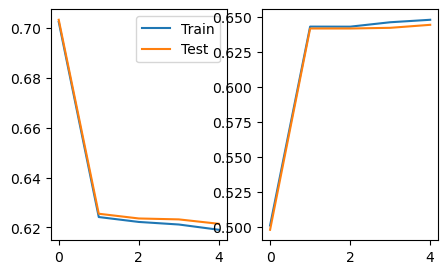

PyObject <matplotlib.legend.Legend object at 0x7f922ebf0940>

In [16]:
fig, ax = plt.subplots(1,2, figsize=(5,3))

loss_vect = result.loss
acc_vector = result.acc

ax[1].plot(loss_vect[1], label="Train")
ax[1].plot(loss_vect[2], label="Test")
ax[2].plot(acc_vector[1])
ax[2].plot(acc_vector[2])
ax[1].legend()

In [17]:
roc_tr = roc_curve(trdata..., model_tmp)
roc_test = roc_curve(tstdata..., model_tmp);

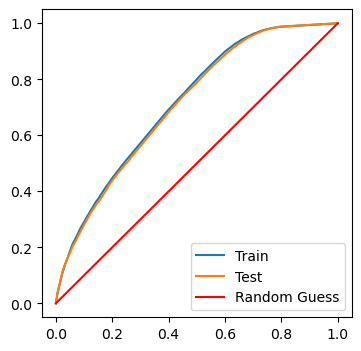

PyObject <matplotlib.legend.Legend object at 0x7f924c0dffd0>

In [18]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.plot(roc_tr.fpr, roc_tr.tpr,  label="Train")
ax.plot(roc_test.fpr, roc_test.tpr, label="Test")
ax.plot(0:1, 0:1, color="red", label="Random Guess")
ax.legend()

In [19]:
@show roc_tr.auc, roc_test.auc

(roc_tr.auc, roc_test.auc) = (0.7186480054822608, 0.7121720342167317)


(0.7186480054822608, 0.7121720342167317)

In [20]:
test_int = 1:120
par_importance = params_importance(x, y, test_int)

i = 1


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69331247
│   loss_test = 0.6934169
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6534361
│   loss_test = 0.6553974
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6513575
│   loss_test = 0.6535651
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6495033
│   loss_test = 0.6528909
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6476471
│   loss_test = 0.651654

 38.273741 seconds (456.12 M allocations: 18.021 GiB, 8.65% gc time)
i = 2


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6948104
│   loss_test = 0.6945941
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244598
│   loss_test = 0.6271215
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62194306
│   loss_test = 0.6251534
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6205466
│   loss_test = 0.6241873
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.619074
│   loss_test = 0.6231385

 37.675654 seconds (456.12 M allocations: 18.021 GiB, 7.39% gc time)
i = 3


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6964478
│   loss_test = 0.6963991
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6241358
│   loss_test = 0.62561023
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62233776
│   loss_test = 0.624471
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6206193
│   loss_test = 0.62351596
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61893773
│   loss_test = 0.6223

 38.262256 seconds (456.12 M allocations: 18.021 GiB, 8.68% gc time)
i = 4


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7019657
│   loss_test = 0.7019807
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6251422
│   loss_test = 0.62374467
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62271416
│   loss_test = 0.6220068
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62174433
│   loss_test = 0.622026
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61974907
│   loss_test = 0.6203

 37.871116 seconds (456.12 M allocations: 18.021 GiB, 7.26% gc time)
i = 5


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69848853
│   loss_test = 0.69820875
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6245487
│   loss_test = 0.6275948
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62192535
│   loss_test = 0.62556833
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6204204
│   loss_test = 0.62539345
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61805046
│   loss_test = 0.6

 40.184010 seconds (456.12 M allocations: 18.021 GiB, 8.91% gc time)
i = 6


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6940348
│   loss_test = 0.6940993
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62485594
│   loss_test = 0.6266547
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6226915
│   loss_test = 0.62515104
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6211799
│   loss_test = 0.62433994
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6186737
│   loss_test = 0.6223

 38.348289 seconds (456.12 M allocations: 18.021 GiB, 7.74% gc time)
i = 7


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70332247
│   loss_test = 0.70299286
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6251874
│   loss_test = 0.6269035
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6233034
│   loss_test = 0.62567824
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6206737
│   loss_test = 0.62379354
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61914873
│   loss_test = 0.62

 38.845190 seconds (456.12 M allocations: 18.021 GiB, 8.65% gc time)
i = 8


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6929193
│   loss_test = 0.69321907
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6246437
│   loss_test = 0.62636894
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6217326
│   loss_test = 0.6248131
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62012315
│   loss_test = 0.6236947
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6183256
│   loss_test = 0.6225

 38.269029 seconds (456.12 M allocations: 18.021 GiB, 7.53% gc time)
i = 9


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6961926
│   loss_test = 0.6965585
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6251003
│   loss_test = 0.6287866
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6225545
│   loss_test = 0.626712
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62095034
│   loss_test = 0.6259762
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61878365
│   loss_test = 0.625054

 38.792104 seconds (456.12 M allocations: 18.021 GiB, 8.77% gc time)
i = 10


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6947193
│   loss_test = 0.6945016
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62553126
│   loss_test = 0.62481636
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6232408
│   loss_test = 0.6226397
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6214659
│   loss_test = 0.6213457
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6200919
│   loss_test = 0.62054

 38.430468 seconds (456.12 M allocations: 18.021 GiB, 7.62% gc time)
i = 11


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6960028
│   loss_test = 0.696064
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6242923
│   loss_test = 0.62544113
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.622062
│   loss_test = 0.6242688
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62027603
│   loss_test = 0.6231227
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61847746
│   loss_test = 0.621831

 38.972613 seconds (456.12 M allocations: 18.021 GiB, 8.72% gc time)
i = 12


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69349176
│   loss_test = 0.6934183
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6247743
│   loss_test = 0.62630826
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6223128
│   loss_test = 0.62501824
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62056583
│   loss_test = 0.62422407
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6184774
│   loss_test = 0.62

 38.742269 seconds (456.12 M allocations: 18.021 GiB, 7.53% gc time)
i = 13


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6913028
│   loss_test = 0.69129485
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6245071
│   loss_test = 0.6262563
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6227235
│   loss_test = 0.6249231
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6206546
│   loss_test = 0.62370163
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6189077
│   loss_test = 0.62239

 39.017396 seconds (456.12 M allocations: 18.021 GiB, 8.96% gc time)
i = 14


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.698955
│   loss_test = 0.6994854
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244906
│   loss_test = 0.6267509
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6226943
│   loss_test = 0.62532514
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62282556
│   loss_test = 0.6261483
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61990565
│   loss_test = 0.62389

 38.291456 seconds (456.12 M allocations: 18.021 GiB, 7.71% gc time)
i = 15


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6999516
│   loss_test = 0.70064026
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62507427
│   loss_test = 0.624345
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6228661
│   loss_test = 0.6229388
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62095964
│   loss_test = 0.6218453
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6192944
│   loss_test = 0.62087

 38.747907 seconds (456.12 M allocations: 18.021 GiB, 8.98% gc time)
i = 16


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6967721
│   loss_test = 0.69718134
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244137
│   loss_test = 0.62554246
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62252575
│   loss_test = 0.62395227
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62072414
│   loss_test = 0.6231973
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.618292
│   loss_test = 0.621

 38.184808 seconds (456.12 M allocations: 18.021 GiB, 7.75% gc time)
i = 17


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7193814
│   loss_test = 0.7199277
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62590355
│   loss_test = 0.627745
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62313026
│   loss_test = 0.62553114
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62246245
│   loss_test = 0.6252745
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6197978
│   loss_test = 0.6235

 38.900746 seconds (456.12 M allocations: 18.021 GiB, 8.94% gc time)
i = 18


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6945274
│   loss_test = 0.69412744
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6241183
│   loss_test = 0.6252176
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62283385
│   loss_test = 0.625061
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62056106
│   loss_test = 0.62307703
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191733
│   loss_test = 0.6226

 38.288553 seconds (456.12 M allocations: 18.021 GiB, 7.69% gc time)
i = 19


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69447994
│   loss_test = 0.6942928
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62471616
│   loss_test = 0.62694967
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6219464
│   loss_test = 0.6245241
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6205148
│   loss_test = 0.62397116
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6194485
│   loss_test = 0.623

 38.897950 seconds (456.12 M allocations: 18.021 GiB, 8.98% gc time)
i = 20


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.691353
│   loss_test = 0.6917928
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62458426
│   loss_test = 0.625718
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62242335
│   loss_test = 0.62367475
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62094903
│   loss_test = 0.62388384
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.619389
│   loss_test = 0.62260

 39.154109 seconds (456.12 M allocations: 18.021 GiB, 7.59% gc time)
i = 21


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7021665
│   loss_test = 0.7034864
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6246231
│   loss_test = 0.6258396
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6225345
│   loss_test = 0.62381715
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6208114
│   loss_test = 0.622979
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6188726
│   loss_test = 0.6215706

 39.069434 seconds (456.12 M allocations: 18.021 GiB, 8.96% gc time)
i = 22


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69314486
│   loss_test = 0.69306046
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6250447
│   loss_test = 0.62708783
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6223134
│   loss_test = 0.6255871
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6208879
│   loss_test = 0.6244172
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191859
│   loss_test = 0.6234

 38.553699 seconds (456.12 M allocations: 18.021 GiB, 7.76% gc time)
i = 23


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6959726
│   loss_test = 0.6960525
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6241205
│   loss_test = 0.62653816
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6219195
│   loss_test = 0.6248
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62059736
│   loss_test = 0.6240835
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6194244
│   loss_test = 0.62348205

 38.856285 seconds (456.12 M allocations: 18.021 GiB, 9.00% gc time)
i = 24


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69785774
│   loss_test = 0.6979946
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62419087
│   loss_test = 0.6252367
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.622128
│   loss_test = 0.62343526
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62102216
│   loss_test = 0.6227419
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61982864
│   loss_test = 0.621

 38.310312 seconds (456.12 M allocations: 18.021 GiB, 7.70% gc time)
i = 25


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69275105
│   loss_test = 0.69253963
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6252434
│   loss_test = 0.62648034
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62355274
│   loss_test = 0.62549675
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6207032
│   loss_test = 0.6232936
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6195628
│   loss_test = 0.62

 39.100549 seconds (456.12 M allocations: 18.021 GiB, 9.02% gc time)
i = 26


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6911842
│   loss_test = 0.69152445
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6257404
│   loss_test = 0.6257082
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62296855
│   loss_test = 0.62368274
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62171465
│   loss_test = 0.6224674
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6207405
│   loss_test = 0.622

 38.356744 seconds (456.12 M allocations: 18.021 GiB, 7.71% gc time)
i = 27


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69357127
│   loss_test = 0.6936347
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244893
│   loss_test = 0.62599605
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62207043
│   loss_test = 0.6238964
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6205187
│   loss_test = 0.6235961
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62037617
│   loss_test = 0.625

 39.365845 seconds (456.12 M allocations: 18.021 GiB, 8.90% gc time)
i = 28


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69346386
│   loss_test = 0.69319874
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6243526
│   loss_test = 0.625579
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62213326
│   loss_test = 0.6238881
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6204123
│   loss_test = 0.6231115
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.618948
│   loss_test = 0.622364

 38.504646 seconds (456.12 M allocations: 18.021 GiB, 7.74% gc time)
i = 29


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6957696
│   loss_test = 0.6954768
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6247461
│   loss_test = 0.6254696
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6222994
│   loss_test = 0.62313265
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6210154
│   loss_test = 0.62251246
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6196453
│   loss_test = 0.62195

 38.823685 seconds (456.12 M allocations: 18.021 GiB, 8.97% gc time)
i = 30


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69662106
│   loss_test = 0.69652295
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6241359
│   loss_test = 0.6258371
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62199533
│   loss_test = 0.62448967
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62073356
│   loss_test = 0.6235515
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6185244
│   loss_test = 0.62

 38.299628 seconds (456.12 M allocations: 18.021 GiB, 7.78% gc time)
i = 31


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7044107
│   loss_test = 0.70501214
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62552005
│   loss_test = 0.6266674
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6232246
│   loss_test = 0.6244028
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6219208
│   loss_test = 0.62337375
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6204273
│   loss_test = 0.6225

 38.851119 seconds (456.12 M allocations: 18.021 GiB, 8.98% gc time)
i = 32


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6925063
│   loss_test = 0.69261116
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62529695
│   loss_test = 0.6268468
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6231982
│   loss_test = 0.6255753
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62136894
│   loss_test = 0.6244664
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61967707
│   loss_test = 0.623

 38.271866 seconds (456.12 M allocations: 18.021 GiB, 7.78% gc time)
i = 33


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69595367
│   loss_test = 0.69558716
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.623672
│   loss_test = 0.6256337
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.621783
│   loss_test = 0.62447745
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62050706
│   loss_test = 0.6236583
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6185637
│   loss_test = 0.62226

 38.925827 seconds (456.12 M allocations: 18.021 GiB, 8.99% gc time)
i = 34


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69499385
│   loss_test = 0.695067
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6239979
│   loss_test = 0.62632185
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6230655
│   loss_test = 0.6256307
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62051266
│   loss_test = 0.6236097
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61873096
│   loss_test = 0.6225

 38.553848 seconds (456.12 M allocations: 18.021 GiB, 7.73% gc time)
i = 35


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69572604
│   loss_test = 0.6960101
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6249636
│   loss_test = 0.6254815
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6227521
│   loss_test = 0.6238935
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.621303
│   loss_test = 0.62300444
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191967
│   loss_test = 0.622043

 39.214786 seconds (456.12 M allocations: 18.021 GiB, 8.84% gc time)
i = 36


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70848644
│   loss_test = 0.7089915
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6243461
│   loss_test = 0.6282288
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6217775
│   loss_test = 0.62584776
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62004554
│   loss_test = 0.62479234
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61806154
│   loss_test = 0.62

 38.851274 seconds (456.12 M allocations: 18.021 GiB, 7.63% gc time)
i = 37


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69875115
│   loss_test = 0.6987884
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62586796
│   loss_test = 0.62592137
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62291634
│   loss_test = 0.6238877
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6217806
│   loss_test = 0.62320787
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.620575
│   loss_test = 0.622

 39.018013 seconds (456.12 M allocations: 18.021 GiB, 8.97% gc time)
i = 38


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6985843
│   loss_test = 0.69686985
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62465495
│   loss_test = 0.62504816
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62273365
│   loss_test = 0.62415767
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6207303
│   loss_test = 0.6227123
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61903846
│   loss_test = 0.6

 38.321091 seconds (456.12 M allocations: 18.021 GiB, 7.72% gc time)
i = 39


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7076973
│   loss_test = 0.7072698
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62536436
│   loss_test = 0.6277297
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62310636
│   loss_test = 0.6259626
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6217247
│   loss_test = 0.624704
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61967003
│   loss_test = 0.62376

 38.813130 seconds (456.12 M allocations: 18.021 GiB, 9.00% gc time)
i = 40


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6946883
│   loss_test = 0.69453704
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6248905
│   loss_test = 0.6268026
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6222418
│   loss_test = 0.6249981
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62046784
│   loss_test = 0.624398
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61829054
│   loss_test = 0.62246

 38.310484 seconds (456.12 M allocations: 18.021 GiB, 7.77% gc time)
i = 41


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69864523
│   loss_test = 0.6989534
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6246259
│   loss_test = 0.62459534
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6224902
│   loss_test = 0.6233369
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62197757
│   loss_test = 0.6232771
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191752
│   loss_test = 0.6214

 41.156843 seconds (456.12 M allocations: 18.021 GiB, 8.66% gc time)
i = 42


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.696068
│   loss_test = 0.6957862
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6242314
│   loss_test = 0.62604666
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6221706
│   loss_test = 0.624486
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6214017
│   loss_test = 0.6250722
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61875117
│   loss_test = 0.6224334

 38.652510 seconds (456.12 M allocations: 18.021 GiB, 7.72% gc time)
i = 43


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70949286
│   loss_test = 0.7092346
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62461174
│   loss_test = 0.62525517
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6224489
│   loss_test = 0.62333065
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.620558
│   loss_test = 0.6227153
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6188904
│   loss_test = 0.6215

 38.848362 seconds (456.12 M allocations: 18.021 GiB, 8.92% gc time)
i = 44


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6974476
│   loss_test = 0.69725674
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62378496
│   loss_test = 0.6268814
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6219875
│   loss_test = 0.62562716
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62029874
│   loss_test = 0.6239284
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6185605
│   loss_test = 0.623

 38.306557 seconds (456.12 M allocations: 18.021 GiB, 7.65% gc time)
i = 45


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69487345
│   loss_test = 0.69447166
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62432116
│   loss_test = 0.6281961
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6218774
│   loss_test = 0.6260866
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6195821
│   loss_test = 0.62452847
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6182184
│   loss_test = 0.623

 39.567703 seconds (456.12 M allocations: 18.021 GiB, 8.93% gc time)
i = 46


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70151967
│   loss_test = 0.7021009
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62528825
│   loss_test = 0.62704873
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6233214
│   loss_test = 0.6258528
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62285846
│   loss_test = 0.62604666
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61966807
│   loss_test = 0.6

 39.927460 seconds (456.12 M allocations: 18.021 GiB, 7.53% gc time)
i = 47


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69203067
│   loss_test = 0.6925056
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62467414
│   loss_test = 0.6240265
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62245417
│   loss_test = 0.6221357
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6216189
│   loss_test = 0.62225366
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6197683
│   loss_test = 0.621

 41.815661 seconds (456.12 M allocations: 18.021 GiB, 8.54% gc time)
i = 48


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6959082
│   loss_test = 0.6956599
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6246
│   loss_test = 0.6272366
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6220112
│   loss_test = 0.62496996
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62070745
│   loss_test = 0.6243197
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61870515
│   loss_test = 0.6232607

 39.004277 seconds (456.12 M allocations: 18.021 GiB, 7.64% gc time)
i = 49


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69422877
│   loss_test = 0.69423956
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62461036
│   loss_test = 0.62452805
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6220202
│   loss_test = 0.623537
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6205878
│   loss_test = 0.6227529
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6185119
│   loss_test = 0.6213

 39.540681 seconds (456.12 M allocations: 18.021 GiB, 8.85% gc time)
i = 50


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7198125
│   loss_test = 0.71936816
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6253666
│   loss_test = 0.6277329
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62254685
│   loss_test = 0.62616676
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6208936
│   loss_test = 0.6251481
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6180631
│   loss_test = 0.6237

 39.715530 seconds (456.12 M allocations: 18.021 GiB, 9.06% gc time)
i = 51


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7123162
│   loss_test = 0.7109544
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6237112
│   loss_test = 0.6269555
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62121224
│   loss_test = 0.6250969
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61987984
│   loss_test = 0.6243258
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61835855
│   loss_test = 0.6237

 38.968934 seconds (456.12 M allocations: 18.021 GiB, 8.94% gc time)
i = 52


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6911023
│   loss_test = 0.69131845
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6251983
│   loss_test = 0.62534463
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6226528
│   loss_test = 0.6237707
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62132126
│   loss_test = 0.6230209
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6188918
│   loss_test = 0.6211

 39.062918 seconds (456.12 M allocations: 18.021 GiB, 8.95% gc time)
i = 53


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6943595
│   loss_test = 0.69410354
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6252104
│   loss_test = 0.6244097
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62268656
│   loss_test = 0.62262756
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6219528
│   loss_test = 0.62175673
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6193496
│   loss_test = 0.620

 39.425116 seconds (456.12 M allocations: 18.021 GiB, 8.91% gc time)
i = 54


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6954802
│   loss_test = 0.6961522
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6248207
│   loss_test = 0.62774074
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62246436
│   loss_test = 0.6255937
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62011516
│   loss_test = 0.6235408
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6182726
│   loss_test = 0.6227

 38.830484 seconds (456.12 M allocations: 18.021 GiB, 8.97% gc time)
i = 55


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7123472
│   loss_test = 0.711701
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6240032
│   loss_test = 0.6255384
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6220015
│   loss_test = 0.62388915
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62061924
│   loss_test = 0.6237753
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191673
│   loss_test = 0.622742

 38.920306 seconds (456.12 M allocations: 18.021 GiB, 8.94% gc time)
i = 56


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6910644
│   loss_test = 0.6914837
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62378675
│   loss_test = 0.62589926
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6223157
│   loss_test = 0.6247981
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6199352
│   loss_test = 0.6231145
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6182907
│   loss_test = 0.62293

 39.248135 seconds (456.12 M allocations: 18.021 GiB, 8.97% gc time)
i = 57


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7028575
│   loss_test = 0.7028876
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62410694
│   loss_test = 0.62828964
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6212903
│   loss_test = 0.6261824
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61959165
│   loss_test = 0.62543064
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61861414
│   loss_test = 0.62

 39.127750 seconds (456.12 M allocations: 18.021 GiB, 9.12% gc time)
i = 58


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6947134
│   loss_test = 0.69505584
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62541926
│   loss_test = 0.627897
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6232256
│   loss_test = 0.6260658
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62181574
│   loss_test = 0.6253302
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6198508
│   loss_test = 0.62382

 38.831410 seconds (456.12 M allocations: 18.021 GiB, 9.01% gc time)
i = 59


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.691632
│   loss_test = 0.69170564
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244534
│   loss_test = 0.6256199
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62224877
│   loss_test = 0.6236761
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62070245
│   loss_test = 0.62302816
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61925423
│   loss_test = 0.621

 38.900765 seconds (456.12 M allocations: 18.021 GiB, 8.99% gc time)
i = 60


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6955312
│   loss_test = 0.6952484
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6249453
│   loss_test = 0.6241049
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6226415
│   loss_test = 0.62268955
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62109774
│   loss_test = 0.6219442
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6196703
│   loss_test = 0.62025

 38.693897 seconds (456.12 M allocations: 18.021 GiB, 8.97% gc time)
i = 61


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69331205
│   loss_test = 0.6931535
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62441343
│   loss_test = 0.6247472
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6221347
│   loss_test = 0.6236578
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6213376
│   loss_test = 0.6232161
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191725
│   loss_test = 0.62229

 39.315884 seconds (456.12 M allocations: 18.021 GiB, 9.07% gc time)
i = 62


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69592
│   loss_test = 0.6955436
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62471884
│   loss_test = 0.6254183
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6222589
│   loss_test = 0.62367994
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62100357
│   loss_test = 0.62301993
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6189802
│   loss_test = 0.62103

 38.946999 seconds (456.12 M allocations: 18.021 GiB, 9.07% gc time)
i = 63


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6937871
│   loss_test = 0.69358355
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62457937
│   loss_test = 0.62803805
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6217367
│   loss_test = 0.62551445
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6199201
│   loss_test = 0.6242056
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6183599
│   loss_test = 0.623

 39.706698 seconds (456.12 M allocations: 18.021 GiB, 9.03% gc time)
i = 64


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7045662
│   loss_test = 0.7049588
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62510926
│   loss_test = 0.6281813
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62167376
│   loss_test = 0.62472814
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6209588
│   loss_test = 0.62453026
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6180672
│   loss_test = 0.622

 40.501572 seconds (456.12 M allocations: 18.021 GiB, 8.73% gc time)
i = 65


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6961239
│   loss_test = 0.6962155
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244043
│   loss_test = 0.6247612
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6224731
│   loss_test = 0.62374264
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6209813
│   loss_test = 0.6229078
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6193028
│   loss_test = 0.621615

 39.735790 seconds (456.12 M allocations: 18.021 GiB, 9.01% gc time)
i = 66


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6938976
│   loss_test = 0.6938857
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62435377
│   loss_test = 0.6267189
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62168103
│   loss_test = 0.62509304
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62072265
│   loss_test = 0.62555623
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61829555
│   loss_test = 0.6

 39.064498 seconds (456.12 M allocations: 18.021 GiB, 9.02% gc time)
i = 67


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6948167
│   loss_test = 0.6951009
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6236067
│   loss_test = 0.6269343
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62161934
│   loss_test = 0.6254469
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62119395
│   loss_test = 0.62573767
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6184543
│   loss_test = 0.6234

 39.089099 seconds (456.12 M allocations: 18.021 GiB, 9.03% gc time)
i = 68


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69791836
│   loss_test = 0.69792396
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6248102
│   loss_test = 0.62590337
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6225949
│   loss_test = 0.6246236
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62110275
│   loss_test = 0.62396914
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6190972
│   loss_test = 0.62

 39.064008 seconds (456.12 M allocations: 18.021 GiB, 9.08% gc time)
i = 69


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7374973
│   loss_test = 0.7368337
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62609273
│   loss_test = 0.6248354
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62264264
│   loss_test = 0.62222415
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62121695
│   loss_test = 0.6216096
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6201518
│   loss_test = 0.621

 39.096975 seconds (456.12 M allocations: 18.021 GiB, 9.00% gc time)
i = 70


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69612575
│   loss_test = 0.69568855
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62618
│   loss_test = 0.62562066
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6226599
│   loss_test = 0.6228737
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62104833
│   loss_test = 0.62156355
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6193934
│   loss_test = 0.6206

 38.965346 seconds (456.12 M allocations: 18.021 GiB, 9.05% gc time)
i = 71


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70315516
│   loss_test = 0.70278597
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62383515
│   loss_test = 0.6265896
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6216572
│   loss_test = 0.62478876
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6202366
│   loss_test = 0.6242374
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61825794
│   loss_test = 0.62

 39.439314 seconds (456.12 M allocations: 18.021 GiB, 8.93% gc time)
i = 72


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70171195
│   loss_test = 0.7018025
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62497896
│   loss_test = 0.62560993
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62232965
│   loss_test = 0.623669
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6210088
│   loss_test = 0.62269694
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61914563
│   loss_test = 0.62

 39.051198 seconds (456.12 M allocations: 18.021 GiB, 9.04% gc time)
i = 73


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6924516
│   loss_test = 0.69293135
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6241298
│   loss_test = 0.6262306
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6226993
│   loss_test = 0.62576777
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62049997
│   loss_test = 0.6244967
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6184586
│   loss_test = 0.6227

 38.994181 seconds (456.12 M allocations: 18.021 GiB, 9.09% gc time)
i = 74


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6950949
│   loss_test = 0.69491136
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6242966
│   loss_test = 0.6266926
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62280446
│   loss_test = 0.6254367
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6198474
│   loss_test = 0.6233716
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6186823
│   loss_test = 0.62290

 39.019549 seconds (456.12 M allocations: 18.021 GiB, 9.05% gc time)
i = 75


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69063556
│   loss_test = 0.690604
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62476003
│   loss_test = 0.6260472
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62243944
│   loss_test = 0.6240753
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62106067
│   loss_test = 0.6235834
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6196748
│   loss_test = 0.6223

 39.140257 seconds (456.12 M allocations: 18.021 GiB, 9.01% gc time)
i = 76


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69027543
│   loss_test = 0.69058883
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6242256
│   loss_test = 0.62613523
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62201965
│   loss_test = 0.62510186
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6207262
│   loss_test = 0.6243692
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61866534
│   loss_test = 0.6

 39.285274 seconds (456.12 M allocations: 18.021 GiB, 9.02% gc time)
i = 77


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69686264
│   loss_test = 0.69721866
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62512875
│   loss_test = 0.6256782
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6224114
│   loss_test = 0.6235199
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6210341
│   loss_test = 0.62299883
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191982
│   loss_test = 0.621

 38.940631 seconds (456.12 M allocations: 18.021 GiB, 9.08% gc time)
i = 78


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6918683
│   loss_test = 0.69182986
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6243354
│   loss_test = 0.6263321
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6217338
│   loss_test = 0.6244577
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.620368
│   loss_test = 0.6237192
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61853284
│   loss_test = 0.622438

 39.031392 seconds (456.12 M allocations: 18.021 GiB, 9.03% gc time)
i = 79


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7009604
│   loss_test = 0.7010852
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62504864
│   loss_test = 0.62560344
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62201256
│   loss_test = 0.6233327
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62041754
│   loss_test = 0.62254286
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61904097
│   loss_test = 0.6

 39.501508 seconds (456.12 M allocations: 18.021 GiB, 9.03% gc time)
i = 80


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69392496
│   loss_test = 0.6937868
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6248026
│   loss_test = 0.6239187
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62286353
│   loss_test = 0.6224212
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6213915
│   loss_test = 0.6212967
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61938715
│   loss_test = 0.6206

 39.070036 seconds (456.12 M allocations: 18.021 GiB, 9.07% gc time)
i = 81


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.70087934
│   loss_test = 0.6999922
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.623996
│   loss_test = 0.62543654
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6220216
│   loss_test = 0.6237113
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6209137
│   loss_test = 0.62342376
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6189424
│   loss_test = 0.62220

 39.399511 seconds (456.12 M allocations: 18.021 GiB, 9.02% gc time)
i = 82


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6924079
│   loss_test = 0.69244415
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62462866
│   loss_test = 0.62631565
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6220579
│   loss_test = 0.624134
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6214239
│   loss_test = 0.62335527
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61890197
│   loss_test = 0.622

 39.327349 seconds (456.12 M allocations: 18.021 GiB, 9.04% gc time)
i = 83


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6919497
│   loss_test = 0.69207025
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62405854
│   loss_test = 0.6257835
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6220367
│   loss_test = 0.62369055
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62040734
│   loss_test = 0.62283117
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6190045
│   loss_test = 0.62

 39.119879 seconds (456.12 M allocations: 18.021 GiB, 9.05% gc time)
i = 84


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7011167
│   loss_test = 0.70025176
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62614024
│   loss_test = 0.6289125
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6213847
│   loss_test = 0.6248834
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61998683
│   loss_test = 0.6242029
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6185176
│   loss_test = 0.6234

 39.187814 seconds (456.12 M allocations: 18.021 GiB, 9.06% gc time)
i = 85


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69828117
│   loss_test = 0.6981304
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6266453
│   loss_test = 0.62860185
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6223511
│   loss_test = 0.6245491
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62069297
│   loss_test = 0.6235328
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61937004
│   loss_test = 0.622

 38.951135 seconds (456.12 M allocations: 18.021 GiB, 9.08% gc time)
i = 86


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7069492
│   loss_test = 0.7065579
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244599
│   loss_test = 0.62641436
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6221334
│   loss_test = 0.6243296
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62150526
│   loss_test = 0.62392503
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191314
│   loss_test = 0.6226

 39.236765 seconds (456.12 M allocations: 18.021 GiB, 8.96% gc time)
i = 87


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6983419
│   loss_test = 0.6983536
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6242778
│   loss_test = 0.6251557
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6218286
│   loss_test = 0.62378854
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6203765
│   loss_test = 0.62308806
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6187197
│   loss_test = 0.62271

 38.908260 seconds (456.12 M allocations: 18.021 GiB, 9.13% gc time)
i = 88


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6955246
│   loss_test = 0.6953817
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62490845
│   loss_test = 0.62441164
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62279457
│   loss_test = 0.6233946
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6208581
│   loss_test = 0.62222695
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6192646
│   loss_test = 0.620

 38.847260 seconds (456.12 M allocations: 18.021 GiB, 9.11% gc time)
i = 89


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6934254
│   loss_test = 0.69268394
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244842
│   loss_test = 0.6259446
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6219341
│   loss_test = 0.6242836
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62077135
│   loss_test = 0.62412876
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6192856
│   loss_test = 0.6231

 38.854112 seconds (456.12 M allocations: 18.021 GiB, 9.10% gc time)
i = 90


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7182895
│   loss_test = 0.7184195
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6252686
│   loss_test = 0.6249408
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6228376
│   loss_test = 0.6232671
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6210533
│   loss_test = 0.6218115
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61898106
│   loss_test = 0.620572

 38.838417 seconds (456.12 M allocations: 18.021 GiB, 9.10% gc time)
i = 91


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6921658
│   loss_test = 0.6920661
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62460446
│   loss_test = 0.626312
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62277645
│   loss_test = 0.62497276
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6211259
│   loss_test = 0.6243733
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61981297
│   loss_test = 0.6229

 38.956035 seconds (456.12 M allocations: 18.021 GiB, 9.09% gc time)
i = 92


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69206434
│   loss_test = 0.69192284
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6245848
│   loss_test = 0.62390715
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6228165
│   loss_test = 0.62251025
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.620859
│   loss_test = 0.6211244
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61920744
│   loss_test = 0.620

 38.873139 seconds (456.12 M allocations: 18.021 GiB, 9.08% gc time)
i = 93


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69288
│   loss_test = 0.6923662
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6246883
│   loss_test = 0.6247665
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6226426
│   loss_test = 0.6236996
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62109584
│   loss_test = 0.62283957
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6191806
│   loss_test = 0.6217393

 39.082715 seconds (456.12 M allocations: 18.021 GiB, 9.03% gc time)
i = 94


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6987431
│   loss_test = 0.69885236
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62535197
│   loss_test = 0.62527186
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6229911
│   loss_test = 0.62360716
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6211157
│   loss_test = 0.62243235
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6193883
│   loss_test = 0.62

 39.120102 seconds (456.12 M allocations: 18.021 GiB, 9.03% gc time)
i = 95


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6955807
│   loss_test = 0.6959247
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6254593
│   loss_test = 0.6275484
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62243235
│   loss_test = 0.62461257
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62145424
│   loss_test = 0.6243115
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61910444
│   loss_test = 0.622

 38.967104 seconds (456.12 M allocations: 18.021 GiB, 9.07% gc time)
i = 96


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69366294
│   loss_test = 0.6935385
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6245858
│   loss_test = 0.6274392
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62187403
│   loss_test = 0.62566334
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6211982
│   loss_test = 0.62550807
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6181136
│   loss_test = 0.623

 38.900328 seconds (456.12 M allocations: 18.021 GiB, 9.07% gc time)
i = 97


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69850266
│   loss_test = 0.6997615
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6241573
│   loss_test = 0.62752324
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62163514
│   loss_test = 0.6259038
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61987245
│   loss_test = 0.624555
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61842656
│   loss_test = 0.623

 38.761989 seconds (456.12 M allocations: 18.021 GiB, 9.09% gc time)
i = 98


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69463646
│   loss_test = 0.69465345
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6248454
│   loss_test = 0.6267937
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62272286
│   loss_test = 0.62541115
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62067896
│   loss_test = 0.6230029
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61867857
│   loss_test = 0.6

 38.772124 seconds (456.12 M allocations: 18.021 GiB, 9.11% gc time)
i = 99


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6984065
│   loss_test = 0.7001864
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6247565
│   loss_test = 0.6260676
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62196016
│   loss_test = 0.6233914
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6206328
│   loss_test = 0.6224936
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61927706
│   loss_test = 0.62213

 38.861089 seconds (456.12 M allocations: 18.021 GiB, 9.09% gc time)
i = 100


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6962707
│   loss_test = 0.69619983
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62436366
│   loss_test = 0.6284979
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6212658
│   loss_test = 0.6257739
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.619724
│   loss_test = 0.6246162
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61836576
│   loss_test = 0.62369

 39.191618 seconds (456.12 M allocations: 18.021 GiB, 9.10% gc time)
i = 101


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6987241
│   loss_test = 0.70029056
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62527984
│   loss_test = 0.6274152
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62168574
│   loss_test = 0.6239355
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6203484
│   loss_test = 0.6237224
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61840045
│   loss_test = 0.621

 38.941028 seconds (456.12 M allocations: 18.021 GiB, 9.12% gc time)
i = 102


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69772786
│   loss_test = 0.6974295
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6257986
│   loss_test = 0.6254069
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62342036
│   loss_test = 0.623702
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6210811
│   loss_test = 0.622095
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61983776
│   loss_test = 0.621659

 38.777967 seconds (456.12 M allocations: 18.021 GiB, 9.11% gc time)
i = 103


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69187266
│   loss_test = 0.6920237
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62480426
│   loss_test = 0.62760144
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6221347
│   loss_test = 0.62514716
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6212358
│   loss_test = 0.62565863
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61881924
│   loss_test = 0.6

 38.780243 seconds (456.12 M allocations: 18.021 GiB, 9.09% gc time)
i = 104


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6961615
│   loss_test = 0.69667995
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6250168
│   loss_test = 0.6251009
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6224654
│   loss_test = 0.6231488
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6208971
│   loss_test = 0.6224063
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61912066
│   loss_test = 0.62128

 38.752087 seconds (456.12 M allocations: 18.021 GiB, 9.14% gc time)
i = 105


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7030003
│   loss_test = 0.70317054
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62470233
│   loss_test = 0.6265962
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6218824
│   loss_test = 0.6245599
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6206949
│   loss_test = 0.62417495
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61849827
│   loss_test = 0.622

 38.951566 seconds (456.12 M allocations: 18.021 GiB, 9.13% gc time)
i = 106


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6975154
│   loss_test = 0.69763774
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62516516
│   loss_test = 0.62727576
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6230804
│   loss_test = 0.62508667
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6212558
│   loss_test = 0.62435806
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6189542
│   loss_test = 0.62

 40.863434 seconds (456.12 M allocations: 18.021 GiB, 8.91% gc time)
i = 107


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6937361
│   loss_test = 0.69352555
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6244945
│   loss_test = 0.62757695
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6218804
│   loss_test = 0.62569875
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6204405
│   loss_test = 0.6254206
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.619158
│   loss_test = 0.62413

 39.017492 seconds (456.12 M allocations: 18.021 GiB, 9.10% gc time)
i = 108


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6904798
│   loss_test = 0.69032
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6253764
│   loss_test = 0.62392384
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6230306
│   loss_test = 0.6219657
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62204564
│   loss_test = 0.6208904
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6195479
│   loss_test = 0.6186597

 39.457773 seconds (456.12 M allocations: 18.021 GiB, 8.99% gc time)
i = 109


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69380707
│   loss_test = 0.69387937
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6270581
│   loss_test = 0.6276007
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62484026
│   loss_test = 0.62519
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6236406
│   loss_test = 0.62507045
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6215753
│   loss_test = 0.62349

 39.310551 seconds (456.12 M allocations: 18.021 GiB, 9.09% gc time)
i = 110


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69509274
│   loss_test = 0.6949672
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6247206
│   loss_test = 0.6252501
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6219914
│   loss_test = 0.6229866
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6206584
│   loss_test = 0.6223922
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6189907
│   loss_test = 0.621533

 39.164986 seconds (456.12 M allocations: 18.021 GiB, 9.13% gc time)
i = 111


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6944359
│   loss_test = 0.694442
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6249386
│   loss_test = 0.6246074
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6228565
│   loss_test = 0.6230256
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6211018
│   loss_test = 0.62202585
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6192384
│   loss_test = 0.6209490

 39.304302 seconds (456.12 M allocations: 18.021 GiB, 9.10% gc time)
i = 112


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69331527
│   loss_test = 0.69365174
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6246313
│   loss_test = 0.6249379
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62233394
│   loss_test = 0.6231415
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62112707
│   loss_test = 0.6229494
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6195718
│   loss_test = 0.621

 38.994508 seconds (456.12 M allocations: 18.021 GiB, 9.14% gc time)
i = 113


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6954321
│   loss_test = 0.69544035
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6243228
│   loss_test = 0.62563705
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62233335
│   loss_test = 0.62387717
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62040734
│   loss_test = 0.6229372
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6187385
│   loss_test = 0.62

 38.945491 seconds (456.12 M allocations: 18.021 GiB, 9.12% gc time)
i = 114


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69411033
│   loss_test = 0.6939016
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62461865
│   loss_test = 0.62593204
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6220694
│   loss_test = 0.6243012
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62059563
│   loss_test = 0.62368083
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6185666
│   loss_test = 0.62

 39.125044 seconds (456.12 M allocations: 18.021 GiB, 9.16% gc time)
i = 115


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7247845
│   loss_test = 0.7251476
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6251895
│   loss_test = 0.62561226
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62226814
│   loss_test = 0.62354994
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62063736
│   loss_test = 0.62258625
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62040645
│   loss_test = 0.6

 39.204698 seconds (456.12 M allocations: 18.021 GiB, 9.04% gc time)
i = 116


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69974893
│   loss_test = 0.7009351
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62901217
│   loss_test = 0.6278286
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6239754
│   loss_test = 0.6229499
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6209868
│   loss_test = 0.6202435
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6198526
│   loss_test = 0.62007

 39.832039 seconds (456.12 M allocations: 18.021 GiB, 9.03% gc time)
i = 117


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69480497
│   loss_test = 0.69517875
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6253155
│   loss_test = 0.6270316
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6221766
│   loss_test = 0.62416685
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62065053
│   loss_test = 0.623479
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6190907
│   loss_test = 0.6225

 39.600051 seconds (456.12 M allocations: 18.021 GiB, 9.07% gc time)
i = 118


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6965766
│   loss_test = 0.6966754
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6254146
│   loss_test = 0.62740815
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6223428
│   loss_test = 0.6245782
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6209149
│   loss_test = 0.62408936
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6187826
│   loss_test = 0.62263

 39.151830 seconds (456.12 M allocations: 18.021 GiB, 9.15% gc time)
i = 119


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.69365466
│   loss_test = 0.6932615
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6247135
│   loss_test = 0.6250573
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6228305
│   loss_test = 0.62383825
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6211018
│   loss_test = 0.6229016
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6195738
│   loss_test = 0.62214

 39.334252 seconds (456.12 M allocations: 18.021 GiB, 9.11% gc time)
i = 120


┌ Info: Epoch 1
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.7047665
│   loss_test = 0.70433277
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 2
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6242738
│   loss_test = 0.6257522
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 3
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.6223717
│   loss_test = 0.6239843
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 4
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.62107706
│   loss_test = 0.6227807
└ @ Main /Users/vhafych/MPP-Server/gitrepos/COVID_Tweets_Analysis/src/nn.jl:81
┌ Info: Epoch 5
└ @ Main /Users/vhafych/.julia/packages/Flux/q3zeA/src/optimise/train.jl:136
┌ Info: 0.61866045
│   loss_test = 0.6218

 39.606524 seconds (456.12 M allocations: 18.021 GiB, 9.03% gc time)


(test = [0.6576020772537216, 0.711493064468717, 0.7111711151678014, 0.7129316316674583, 0.7101363783652377, 0.7113607027982026, 0.7093762452461672, 0.709923940287659, 0.7062452705825167, 0.7148971460096999  …  0.7118829149559232, 0.713832156238621, 0.711409463476973, 0.7109008650236658, 0.7121349951162759, 0.7171386110562783, 0.7078721067055185, 0.7103961659898482, 0.7116596134657263, 0.7119977370281793], train = [0.6674003406766454, 0.7199384443882635, 0.7185126145893078, 0.7173575606268384, 0.7203265616835506, 0.7214093909043974, 0.720150952492305, 0.7199082350201444, 0.7190270540975532, 0.7183777274542329  …  0.7178428908142067, 0.7177627691556225, 0.720642355634476, 0.7202878093010168, 0.7190406015889537, 0.7181581079402541, 0.7184892990574658, 0.7196906004647434, 0.7186979162007099, 0.7194299887393791])

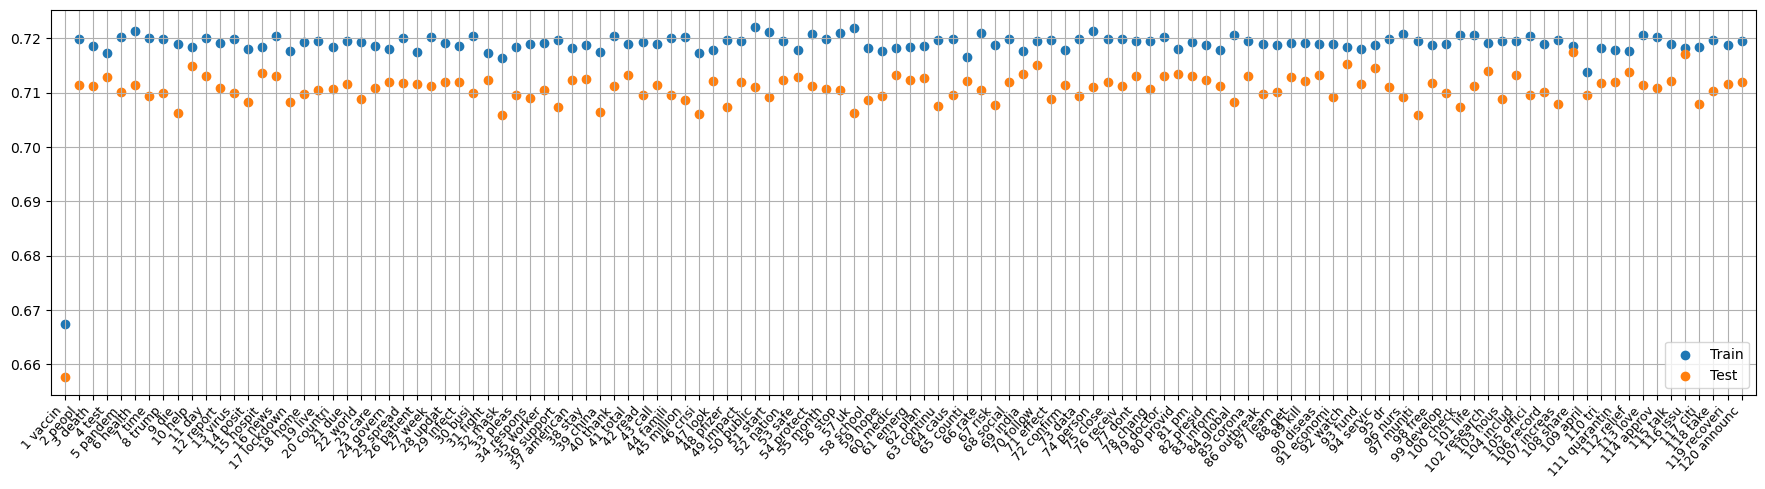

(0.0, 121.0)

In [21]:
fig, ax = plt.subplots(1,1, figsize=(22,5))

ax.scatter(test_int, par_importance.train,  label="Train")
ax.scatter(test_int, par_importance.test, label="Test")
ax.legend()

ax.set_xticks(test_int)

trms_tmp = ["$i " * terms[i] for i in test_int]
ax.set_xticklabels(trms_tmp, rotation = 48, fontsize=9, ha="right");

ax.grid(which="both")

ax.set_xlim(0, maximum(test_int)+1)

# fig.savefig("../plots/eng-nn.png", bbox_inches = "tight", dpi=800)

In [22]:
cvals= log.(1 .+ df.favorite_count)
avals = 1 .+ df.retweet_count ; avals = log.(avals); avals = avals .- (minimum(avals) - 0.1) ; avals = avals ./ maximum(avals)
avals_t = [df.tind[i] == 1 ? plt.cm.Blues_r(avals[i]) : plt.cm.Reds_r(avals[i]) for i in eachindex(df.tind)];

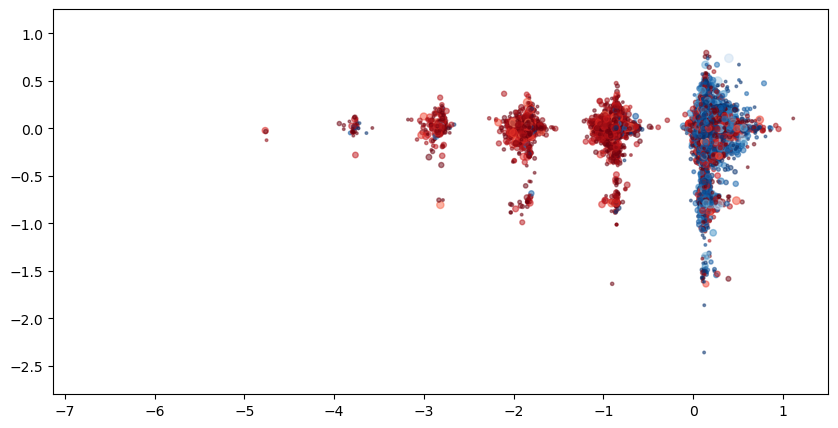

PyObject <matplotlib.collections.PathCollection object at 0x7f91c093bd60>

In [23]:
fig, ax= plt.subplots(1,1, figsize=(10,5))

ax.scatter(Yte[1,:], Yte[112,:], alpha=0.5, s=5.0.*cvals, c=avals_t, rasterized=true, label="April") # 3 / 4 

# ax.set_xlim(-0.4e-5, 0.8e-5)
# ax.set_ylim(-0.4e-5, 0.5e-5)

In [24]:
vars_nn = (test_int, par_importance.train, par_importance.test, terms[test_int])
# JLD2.@save "../data/tmp_files/en-nn.jld" vars_nn

In [33]:
new_terms = terms[sortperm(par_importance.test)][1:40]

40-element Array{String,1}:
 "vaccin"
 "muniti"
 "mask"
 "crisi"
 "die"
 "uk"
 "china"
 "pfizer"
 "support"
 "check"
 "continu"
 "risk"
 "citi"
 ⋮
 "hope"
 "famili"
 "pleas"
 "caus"
 "read"
 "offici"
 "april"
 "home"
 "outbreak"
 "busi"
 "trump"
 "develop"